In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchinfo import summary
import torch.optim.lr_scheduler as lr_scheduler
from tqdm.auto import tqdm
from pathlib import Path
import random
from timeit import default_timer as timer

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from helper_functions import plot_loss_curves
print(torch.__version__)
print(torchvision.__version__)

2.2.0
0.17.0


In [2]:
torch.cuda.is_available()
device = "cuda"

In [3]:
# set up training data
stats = ((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
data_transform_train = transforms.Compose([
    transforms.RandomAffine(degrees=0, shear=20, scale=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
    transforms.RandomRotation(degrees=0),
    transforms.RandomPerspective(),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(*stats,inplace=True)
])

data_transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

train_data = datasets.CIFAR100(root="Tdata",train=True,download=True,
                                  transform = data_transform_train,
                                  target_transform = None)

test_data = datasets.CIFAR100(root="Tdata",train=False,download=True,
                                  transform =data_transform_test,
                                  target_transform = None)

test_data_normal = datasets.CIFAR100(root="Tdata",train=False,download=True,
                                  target_transform = None)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [4]:
len(test_data),len(train_data)

(10000, 50000)

In [7]:
image , label = train_data[0]
class_names = train_data.classes
class_to_idx = train_data.class_to_idx

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

image shape: torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


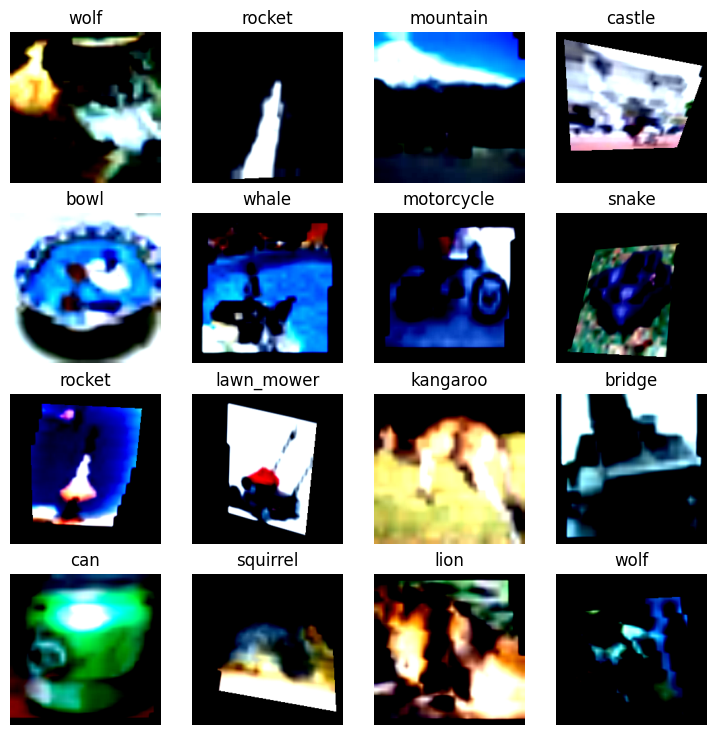

In [8]:
image , label = train_data[0]
print(f"image shape: {image.shape}")

fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0,len(train_data),size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows ,cols ,i)
    plt.imshow(img.permute(1,2,0).squeeze())
    plt.title(class_names[label])
    plt.axis(False);

In [9]:

#set up the bach size hyper parameter
BATCH_SIZE = 64

# TURN DATA SETS INTO ITERABLES (BATCHES)

train_dataloader = DataLoader(dataset  = train_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

test_dataloader = DataLoader(dataset  = test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

len(train_dataloader) , len(test_dataloader)

(782, 157)

In [10]:
def train_step(model : torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer , ):
    model.train()
    
    train_loss ,train_acc = 0,0
    
    for batch, (x,y) in enumerate(dataloader):
        x,y = x.to(device),y.to(device)
        y_pred = model(x)
        
        loss = loss_fn(y_pred,y)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        
        
        loss.backward()
        
        optimizer.step()
        
        
        
        y_pred_class = torch.argmax(torch.softmax(y_pred ,dim=1),dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
        
        

    train_loss = train_loss/ len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss ,train_acc



def test_step(model : torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    
    model.eval()
    
    test_loss , test_acc = 0,0
    
    with torch.inference_mode():
        
        for batch,(x,y) in enumerate(dataloader):
            x,y = x.to(device),y.to(device)
            
            test_pred_logits = model(x)
            
            loss = loss_fn(test_pred_logits , y)
            test_loss += loss.item()
            
            test_pred_labels  =  test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
        test_loss = test_loss / len(dataloader)
        test_acc = test_acc /len(dataloader)
        return test_loss , test_acc

    
    

def train(model_name: str ,
    model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
         
          loss_fn:torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # create an empty result dictionary
    results = {"train_loss" : [],
              "train_acc": [],
              "test_loss": [],
              "test_acc": []}
    max_acc = 0
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model = model,
                                           dataloader=train_dataloader,
                                           loss_fn = loss_fn,
                                           optimizer=optimizer )
        
        test_loss, test_acc = test_step(model = model,
                                           dataloader=test_dataloader,
                                           loss_fn = loss_fn)
        
        
         # print whats happening
        print(f"Epoch: {epoch} | Train loss: {train_loss: .4f} | Train acc: {train_acc: .4f} | Test loss: {test_loss: .4f} | Test acc: {test_acc: .4f} ")
        
        
        
        if test_acc > max_acc:
            #1.create models directory
            MODEL_PATH =  Path("models")
            MODEL_PATH.mkdir(parents=True, exist_ok=True)

            # 2. creat model save path
            MODEL_NAME = f"{model_name}.pth"
            MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

            #save the model stat dict
            print(f"saving model to: {MODEL_SAVE_PATH}")
            torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)
            max_acc = test_acc
            
        
       
        # update result dic
        
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
    return results
    
        


In [11]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        # Stack 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout2d(p=0.2)
        # Stack 2
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.dropout2 = nn.Dropout2d(p=0.5)
        # Stack 3
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.dropout3 = nn.Dropout2d(p=0.5)
        # Fully connected layers
        self.fc1 = nn.Linear(512 * 4 * 4*49, 1000)
        self.dropout4 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(1000, 1000)
        self.dropout5 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(1000, num_classes)

    def forward(self, x):
        # print(x.shape)
        # Stack 1
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        # print(x.shape)
        
        # Stack 2
        x = self.conv3(x)
        x = torch.relu(x)
        x = self.conv4(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.dropout2(x)
        # print(x.shape)
        
        # Stack 3
        x = self.conv5(x)
        x = torch.relu(x)
        x = self.conv6(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.dropout3(x)
        # print(x.shape)
        
        # Flatten
        x = torch.flatten(x, 1)
        # Fully connected layers
        # print(x.shape)
        
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout4(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.dropout5(x)
        x = self.fc3(x)
        # print(x.shape)
        
        return x

# Creating an instance of the CNN model
num_classes = 100  # Assuming num_class is defined elsewhere
model_1= CNN(num_classes)


In [ ]:
# summary(model_1 , input_size=[1,3,32,32])

In [17]:
NUM_EPOCHS = 200

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                            lr = 0.0001)

from timeit import default_timer as timer
start_time = timer()
model_0_results = train(model_name="effetentNet",model= model_1,
                       train_dataloader=  train_dataloader,
                       test_dataloader= test_dataloader,
                       optimizer = optimizer,
                       loss_fn=loss_fn,
                       epochs=NUM_EPOCHS)
end_time = timer()
print(f"total training time for model_1: {end_time - start_time:.3f} seconds")

  0%|          | 0/200 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 392.00 MiB. GPU 0 has a total capacity of 2.00 GiB of which 0 bytes is free. Of the allocated memory 8.64 GiB is allocated by PyTorch, and 217.45 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)